In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Track analysis

         lon        lat          x           y
0  50.510539  26.031766   0.000000    0.000000
1  50.510633  26.034797  10.464032  375.508776
2  50.510722  26.036782  20.371467  621.434496
3  50.510764  26.036871  25.046885  632.460986
4  50.510852  26.036885  34.843001  634.195491


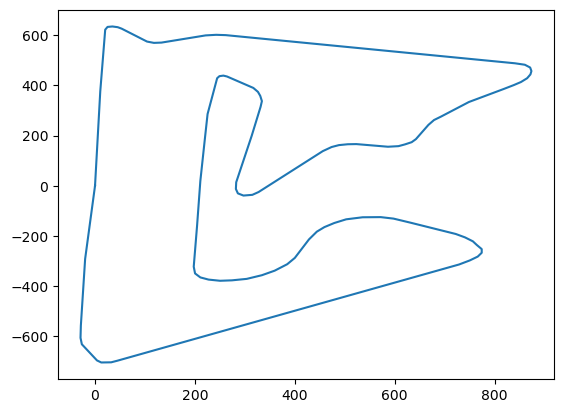

In [10]:
import json

track_name = "Sakhir"

# Read data from geojson file
file = open("./datasets/f1-circuits.geojson", "rb")
content = file.read()
tracks_data = json.loads(content)["features"]

# Select track coordinates
select_gp = [x["geometry"]["coordinates"] for x in tracks_data if x["properties"]["Location"] == track_name]
track_data = pd.DataFrame(select_gp[0], columns=["lon", "lat"])


def latlon_to_xy(lat, lon, origin_lat, origin_lon):

    # WGS84 ellipsoid constants
    EARTH_RADIUS = 6378137.0  # Earth's radius in meters
    
    def deg_to_rad(degrees):
        return degrees * (np.pi / 180.0)
    
    # Convert to radians
    lat_rad = deg_to_rad(lat)
    lon_rad = deg_to_rad(lon)
    origin_lat_rad = deg_to_rad(origin_lat)
    origin_lon_rad = deg_to_rad(origin_lon)
    
    # Mercator projection
    x = EARTH_RADIUS * (lon_rad - origin_lon_rad)
    y = EARTH_RADIUS * np.log(
        np.tan(np.pi/4 + lat_rad/2) / 
        np.tan(np.pi/4 + origin_lat_rad/2)
    )
    
    return pd.Series([x, y])

# Convert latlon track coordinates to xy coordinates
track_data[["x", "y"]] = track_data.apply(lambda row: latlon_to_xy(row["lat"], row["lon"], track_data["lat"][0], track_data["lon"][0]), axis=1)

print(track_data.head())
plt.plot(track_data["x"], track_data["y"])


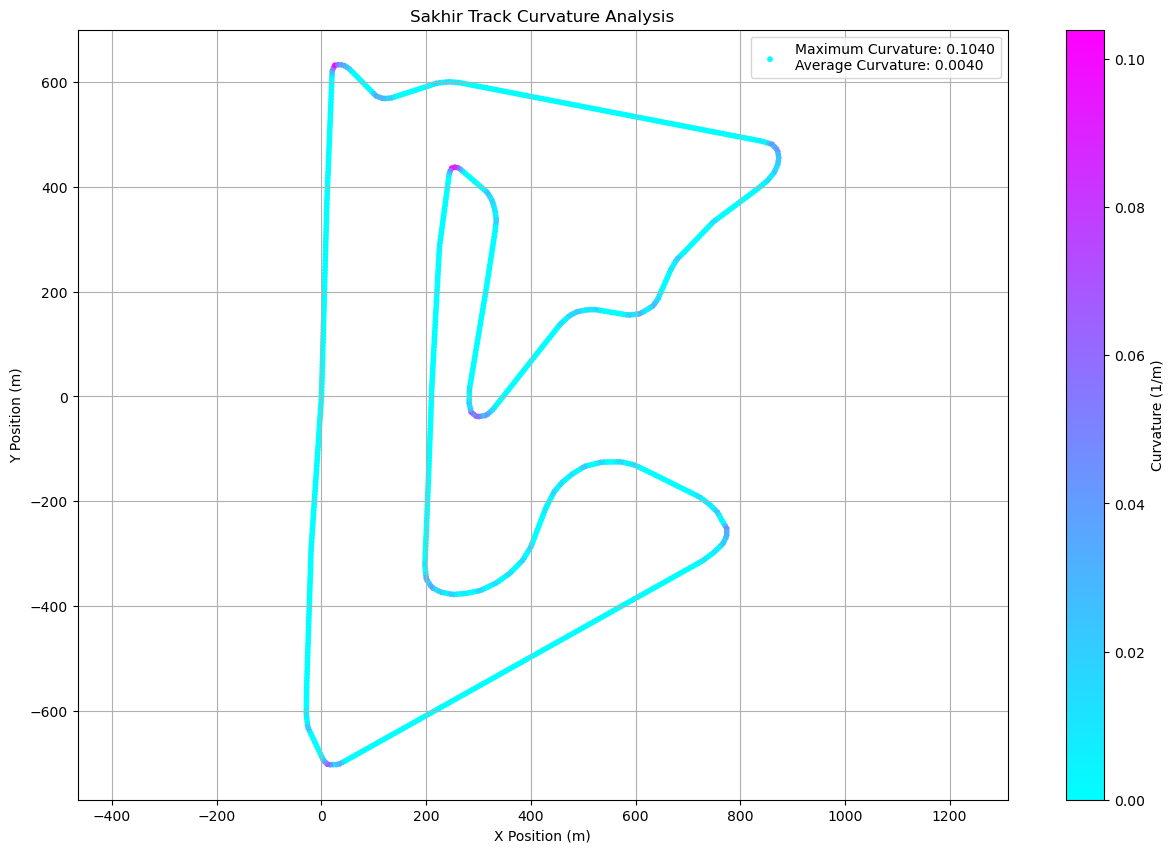

Maximum curvature: 0.1040 m^-1
Average curvature: 0.0040 m^-1
Minimum curvature: 0.0000 m^-1


In [11]:
from scipy.interpolate import splprep, splev

def smooth_track_data(x, y, num_points=1000):

    # Remove duplicate consecutive points
    points = np.column_stack((x, y))
    unique_points = np.vstack([tuple(row) for row in points])
    x, y = unique_points.T
    
    # Fit a B-spline
    tck, u = splprep([x, y], s=0, k=1, per=True)
    
    # Generate points along the smoothed curve
    u_new = np.linspace(0, 1, num_points)
    x_new, y_new = splev(u_new, tck)
    
    return x_new, y_new

def calculate_curvature(x, y):

    # Ensure inputs are numpy arrays
    x = np.array(x)
    y = np.array(y)
    
    # Calculate first derivatives
    dx_dt = np.gradient(x)
    dy_dt = np.gradient(y)
    
    # Calculate second derivatives
    d2x_dt2 = np.gradient(dx_dt)
    d2y_dt2 = np.gradient(dy_dt)
    
    # Calculate curvature using the formula
    curvature = np.abs(dx_dt * d2y_dt2 - dy_dt * d2x_dt2) / (dx_dt**2 + dy_dt**2)**(3/2)
    
    return curvature

def plot_track_curvature(x, y, curvature):

    plt.figure(figsize=(15, 10))
    
    # Plot track colored by curvature
    points = plt.scatter(x, y, c=curvature, cmap='cool', 
                        s=10, 
                        label=f'Maximum Curvature: {np.max(curvature):.4f}\nAverage Curvature: {np.mean(curvature):.4f}'
            )
    plt.colorbar(points, label='Curvature (1/m)')
    plt.legend()
    plt.title(f'{track_name} Track Curvature Analysis')
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.axis('equal')
    plt.grid(True)
    plt.show()


x_smooth, y_smooth = smooth_track_data(track_data["x"].values, track_data["y"].values)

curvature = calculate_curvature(x_smooth, y_smooth)

plot_track_curvature(x_smooth, y_smooth, curvature)

print(f"Maximum curvature: {np.max(curvature):.4f} m^-1")
print(f"Average curvature: {np.mean(curvature):.4f} m^-1")
print(f"Minimum curvature: {np.min(curvature):.4f} m^-1")


### Telemetry data analysis

In [168]:
circuit_name = "Japan"
lap_data = pd.read_csv(f"./datasets/lapdata/{circuit_name}_Grand_Prix.csv")
telem_data = pd.read_csv(f"./datasets/telemetry_data/{circuit_name}_time_series.csv")

In [169]:
driver_id = "VER"

In [170]:
driver_laps = lap_data.loc[lap_data["Driver"] == driver_id]
driver_race_time = pd.to_datetime(driver_laps["LapTime"].sum(), unit="s").time()
driver_laps = driver_laps.set_index(pd.to_datetime(driver_laps["LapStartDate"])).drop(["LapStartDate"], axis=1)
print(driver_race_time)
print(driver_laps.head())

01:22:59.513000
                         DriverNumber Driver  LapNumber Compound  TyreLife  \
LapStartDate                                                                 
2024-04-07 05:03:42.056             1    VER        1.0   MEDIUM       1.0   
2024-04-07 05:32:00.408             1    VER        2.0   MEDIUM       2.0   
2024-04-07 05:34:24.323             1    VER        3.0   MEDIUM       3.0   
2024-04-07 05:37:17.142             1    VER        4.0   MEDIUM       4.0   
2024-04-07 05:38:53.614             1    VER        5.0   MEDIUM       5.0   

                         Sector1Time  Sector2Time  Sector3Time  LapTime  \
LapStartDate                                                              
2024-04-07 05:03:42.056          NaN       64.045       31.458  130.735   
2024-04-07 05:32:00.408          NaN       56.617       39.032      NaN   
2024-04-07 05:34:24.323          NaN       42.768       18.603      NaN   
2024-04-07 05:37:17.142       34.772       43.042       18.658

In [171]:
print(telem_data.head())
driver_telemetry = telem_data.loc[telem_data["Driver"] == driver_id] \
        [["Date", "RPM", "Speed", "nGear", "Throttle", "X", "Y"]]

driver_telemetry = driver_telemetry \
            .set_index(pd.to_datetime(driver_telemetry["Date"])).drop(["Date"], axis=1)

driver_telemetry.head(n=10)

                      Date    RPM  Speed  nGear  Throttle  Brake  DRS  \
0  2024-04-07 05:03:42.056  10043      0      1        16   True    1   
1  2024-04-07 05:03:42.122  10043      0      1        16   True    1   
2  2024-04-07 05:03:42.244  10044      0      1        16   True    1   
3  2024-04-07 05:03:42.322   9499      0      1        16   True    1   
4  2024-04-07 05:03:42.542   8954      0      1        16   True    1   

                     Time             SessionTime  DriverAhead  \
0         0 days 00:00:00  0 days 01:02:40.422000          NaN   
1  0 days 00:00:00.066000  0 days 01:02:40.488000          NaN   
2  0 days 00:00:00.188000  0 days 01:02:40.610000          NaN   
3  0 days 00:00:00.266000  0 days 01:02:40.688000          NaN   
4  0 days 00:00:00.486000  0 days 01:02:40.908000          NaN   

   DistanceToDriverAhead     X     Y  LapNumber  TrackStatus  DriverNumber  \
0               0.111111  3513 -2962        1.0          125             1   
1       

,RPM,Speed,nGear,Throttle,X,Y
Date,,,,,,
2024-04-07 05:03:42.056,10043,0,1,16,3513,-2962
2024-04-07 05:03:42.122,10043,0,1,16,3514,-2963
2024-04-07 05:03:42.244,10044,0,1,16,3514,-2963
2024-04-07 05:03:42.322,9499,0,1,16,3514,-2963
2024-04-07 05:03:42.542,8954,0,1,16,3514,-2963
2024-04-07 05:03:42.644,8409,0,1,16,3515,-2965
2024-04-07 05:03:42.804,7289,11,1,16,3519,-2970
2024-04-07 05:03:42.882,6589,14,1,16,3521,-2973
2024-04-07 05:03:43.004,5889,17,1,16,3523,-2975


In [173]:
################ Merge race data with telemetry data ################
select_lap_data = driver_laps[["LapNumber", "TrackStatus", "Compound", "TyreLife"]]

additional_columns = ["TrackStatus", "Compound"]

def merge_race_data(driver_telemetry: pd.DataFrame, select_lap_data: pd.DataFrame):
    lap_times = select_lap_data.index
    lap_numbers = select_lap_data['LapNumber']

    # Initialize lap column
    result_df = driver_telemetry.copy()
    result_df['LapNumber'] = None

    # Assign lap numbers
    for i in range(len(lap_times)-1):
        current_lap_start = lap_times[i]
        next_lap_start = lap_times[i+1]
        current_lap_number = lap_numbers.iloc[i]
        
        # Assign lap number to all rows between current and next lap start
        mask = (result_df.index >= current_lap_start) & (result_df.index < next_lap_start)
        result_df.loc[mask, 'LapNumber'] = current_lap_number

        for col in additional_columns:
            result_df.loc[mask, col] = select_lap_data[col].iloc[i]

    # Handle last lap
    last_lap_mask = result_df.index >= lap_times[-1]
    result_df.loc[last_lap_mask, 'LapNumber'] = lap_numbers.iloc[-1]

    # Handle additional columns for last lap
    for col in additional_columns:
        result_df.loc[last_lap_mask, col] = select_lap_data[col].iloc[-1]

    driver_telemetry = result_df.copy()

    return driver_telemetry


Text(0.5, 1.0, 'Timeseries data sampling step')

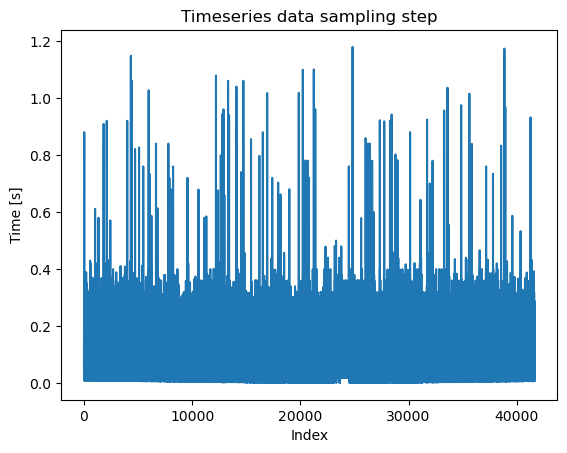

In [159]:
########### Check data sampling step ###########
DT = (driver_telemetry.index[1:] - driver_telemetry.index[:-1]).total_seconds()
plt.plot(np.arange(len(driver_telemetry.index[:-1])), DT)
plt.ylabel("Time [s]")
plt.xlabel("Index")
plt.title("Timeseries data sampling step")

#### Current approach

In [174]:
def resample_and_interpolate_data(driver_telemetry: pd.DataFrame):
    car_data = pd.DataFrame(
        {
            "Speed": driver_telemetry["Speed"].values / 3.6, # convert from km/h to m/s
            "X": driver_telemetry["X"].values,
            "Y": driver_telemetry["Y"].values
        },
        index = driver_telemetry.index
    )


    resampled_telemetry = car_data.resample('300ms').agg({
        'Speed': 'mean',
        'X': 'mean',
        'Y': 'mean'
    }).interpolate(method="linear", limit_direction="forward", axis=0)

    return resampled_telemetry

resampled_telem = resample_and_interpolate_data(driver_telemetry)

merged_telem_lap = merge_race_data(resampled_telem, select_lap_data).dropna()
merged_telem_lap


,Speed,X,Y,LapNumber,TrackStatus,Compound
Date,,,,,,
2024-04-07 05:03:42.300,0.000000,3514.000000,-2963.000000,1.0,125.0,MEDIUM
2024-04-07 05:03:42.600,2.314815,3518.333333,-2969.333333,1.0,125.0,MEDIUM
2024-04-07 05:03:42.900,4.722222,3523.000000,-2975.000000,1.0,125.0,MEDIUM
2024-04-07 05:03:43.200,6.805556,3530.500000,-2983.500000,1.0,125.0,MEDIUM
2024-04-07 05:03:43.500,10.416667,3552.000000,-3008.000000,1.0,125.0,MEDIUM
...,...,...,...,...,...,...
2024-04-07 06:58:04.500,67.777778,1061.500000,-127.500000,53.0,1.0,HARD
2024-04-07 06:58:04.800,69.814815,1257.666667,-330.333333,53.0,1.0,HARD
2024-04-07 06:58:05.100,70.833333,1386.000000,-472.000000,53.0,1.0,HARD


In [175]:
########### Calculate car acceleration ###########

acceleration = np.gradient(merged_telem_lap["Speed"].values)

merged_telem_lap["Acceleration"] = acceleration

velocity_data = merged_telem_lap[["Speed", "LapNumber"]]

merged_telem_lap['Acceleration'] = merged_telem_lap['Acceleration'].clip(lower=-1.0)
positive_acceleration_data = merged_telem_lap[merged_telem_lap["Acceleration"] >= 0.0][["Acceleration", "LapNumber", "X", "Y"]]

In [176]:
def resample_lap_data(df: pd.DataFrame, n_samples: int, value_columns: list[str]):

    resampled_laps = []

    # Process each lap
    for lap_num in df["LapNumber"].unique():
        lap_data = df[df["LapNumber"] == lap_num].copy()
        
        # Calculate percentage of lap completion (0 to 1)
        lap_data['LapProgress'] = (lap_data.index - lap_data.index.min()) / \
                                 (lap_data.index.max() - lap_data.index.min())
        
        # Create new evenly spaced points for interpolation
        new_points = np.linspace(0, 1, n_samples)
        
        # Initialize resampled lap with basic columns
        resampled_lap = pd.DataFrame({
            "LapNumber": lap_num,
            'SampleIndex': range(n_samples),
            'LapProgress': new_points
        })
        
        # Interpolate each value column
        for column in value_columns:
            resampled_lap[column] = np.interp(new_points,
                                            lap_data['LapProgress'],
                                            lap_data[column])
        
        resampled_laps.append(resampled_lap)
    
    # Combine all resampled laps
    result = pd.concat(resampled_laps, ignore_index=True)
    
    return result

max_lap_samples_count = max(positive_acceleration_data.groupby("LapNumber").count()["Acceleration"])
resampled_accel_lap_data = resample_lap_data(positive_acceleration_data, max_lap_samples_count, ["Acceleration", "X", "Y"])


In [177]:
resampled_accel_lap_data

,LapNumber,SampleIndex,LapProgress,Acceleration,X,Y
0,1.0,0,0.000000,2.314815,3514.000000,-2963.000000
1,1.0,1,0.000184,2.356563,3518.516710,-2969.556004
2,1.0,2,0.000367,2.292670,3523.589423,-2975.668013
3,1.0,3,0.000551,2.896341,3533.034521,-2986.388175
4,1.0,4,0.000734,3.296635,3556.636798,-3013.422696
...,...,...,...,...,...,...
288686,53.0,5442,0.999266,1.307042,1637.612560,-768.574734
288687,53.0,5443,0.999449,1.304355,1644.459420,-776.514384
288688,53.0,5444,0.999633,1.301669,1651.306280,-784.454034
288689,53.0,5445,0.999816,1.298983,1658.153140,-792.393683


In [178]:
m_car = 798
m_fuel = 110
mu = 0.9

laps = positive_acceleration_data["LapNumber"].unique()
n_laps = len(laps)
m_total = m_car + m_fuel
fuel_consumption = m_fuel / n_laps # Linear fuel consuption by each lap


accel_force_data = []
for lap in laps:
    accel_force_data.append(
        ((
            m_total * 
            resampled_accel_lap_data[resampled_accel_lap_data["LapNumber"] == lap]["Acceleration"].values
        ) / mu).tolist()
    )
    m_fuel -= fuel_consumption
    m_total = m_car + m_fuel

flattened_accel_force_data = sum(accel_force_data, [])
resampled_accel_lap_data["AccelForce"] = flattened_accel_force_data


Text(0.5, 1.0, 'Japan')

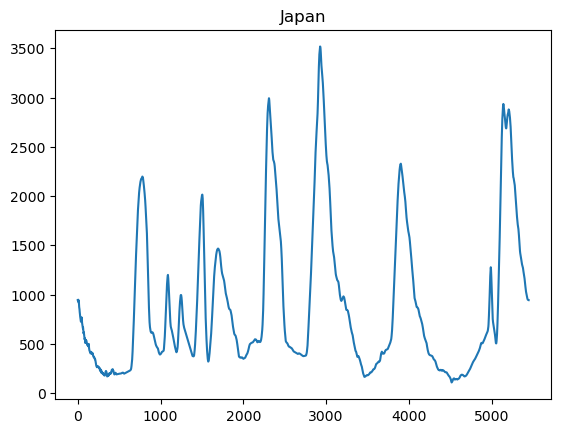

In [179]:
# Calculate stats for each track position for all laps

resampled_accel_lap_data

stats = resampled_accel_lap_data.groupby('SampleIndex').agg({
    "AccelForce": ['mean', 'std', 'min', 'max']
}).reset_index()

stats.columns = ['SampleIndex', 'Mean', 'Std', 'Min', 'Max']

stats

plt.plot(np.arange(len(stats)), stats["Mean"])
plt.title(circuit_name)

#### Old approach

In [ ]:
driver_telemetry = merge_race_data(driver_telemetry, select_lap_data)
driver_telemetry.head()
select_lap_data.loc[select_lap_data["TrackStatus"] != 1.0]

In [ ]:
car_data = pd.DataFrame(
    {
        "Speed": driver_telemetry["Speed"].values / 3.6, # convert from km/h to m/s
        "LapNumber": driver_telemetry["LapNumber"].values,
        "X": driver_telemetry["X"].values,
        "Y": driver_telemetry["Y"].values
    },
    index = driver_telemetry.index
)

########### Resample and aggregate selected data ###########

downsampled_groups = []
for lap, lap_data in car_data.groupby('LapNumber'):
    lap_downsampled = lap_data.resample('1S').agg({
        'Speed': 'mean',
        'LapNumber': 'first',
        'X': 'first',
        'Y': 'first'
    })

    downsampled_groups.append(lap_downsampled)

resampled_car_data = pd.concat(downsampled_groups).sort_index()

In [152]:
########### Calculate car acceleration ###########

acceleration = np.abs(np.gradient(resampled_car_data["Speed"].values))

resampled_car_data["Acceleration"] = acceleration

In [ ]:
########### Calculate and display car mean velocity and acceleration by lap ###########

compound_colors = {
    'SOFT': 'red',
    'MEDIUM': 'gold',
    'HARD': 'gray',
    'INTERMEDIATE': 'green',
    'WET': 'blue'
}


print(select_lap_data.head())


car_data_by_lap = resampled_car_data.groupby("LapNumber").mean()
print(car_data_by_lap.head())

plt.figure()

lap_compounds = select_lap_data["Compound"].values
laps_tyre_life = select_lap_data["TyreLife"].values
track_statuses = select_lap_data["TrackStatus"].values
current_compound = lap_compounds[0]
start_event_region = -1
end_event_region = -1

# Plot velocity
plt.plot(np.arange(1, len(car_data_by_lap["Speed"])+1), car_data_by_lap["Speed"].values * 3.6, c='blue')

# Plot tire changes
plt.axvline(x=select_lap_data["LapNumber"].values[0], color=compound_colors[current_compound], linestyle='--', label=f"{current_compound}")
for i in range(len(lap_compounds)):
    if i < len(lap_compounds) - 1 and laps_tyre_life[i] >= laps_tyre_life[i + 1]:
        current_compound = lap_compounds[i + 1]
        plt.axvline(x=select_lap_data["LapNumber"].values[i+1], color=compound_colors[current_compound], linestyle='--', label=f"{current_compound}")

    if start_event_region == -1 and track_statuses[i] != 1.0:
        start_event_region = i
    elif track_statuses[i] == 1.0 and track_statuses[i-1] != 1.0:
        end_event_region = i
        # Mark area between laps where any track event occurs (e.g. yellow or red flag, safety car...)
        plt.fill_between(np.arange(start=start_event_region+1, stop=end_event_region+1), car_data_by_lap["Speed"].values[start_event_region:end_event_region] * 3.6, alpha=0.5, color='lightcoral', label="Track Event")
        start_event_region = -1
        end_event_region = -1


plt.xlabel("Lap Number")
plt.ylabel("Velocity [km/h]")
plt.title(f"{driver_id} velocity by lap ({circuit_name})")
plt.grid()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.figure()
plt.plot(np.arange(1, len(car_data_by_lap["Acceleration"])+1), car_data_by_lap["Acceleration"].values, c='blue')
plt.xlabel("LapNumber")
plt.ylabel(r"Acceleration [$m/s^2$]")
plt.title(f"{driver_id} acceleration by lap ({circuit_name})")
plt.grid()

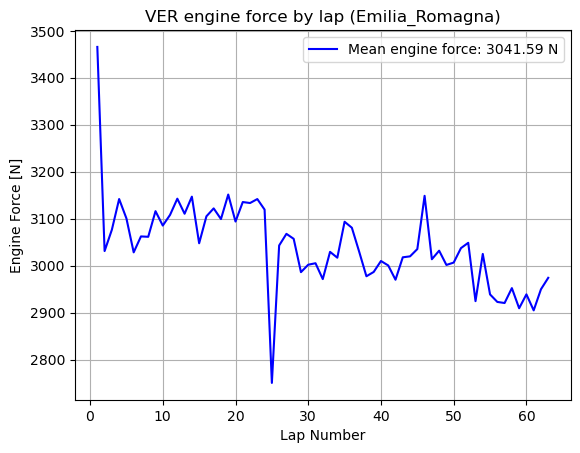

In [156]:
########### Calculate and display mean car engine force by lap ###########

m_car = 798
m_fuel = 110
mu = 1.7

n_laps = len(car_data_by_lap)
m_total = m_car + m_fuel
fuel_consumption = m_fuel / n_laps # Linear fuel consuption by each lap

engine_force_data = []
for accel in car_data_by_lap["Acceleration"].values:
    engine_force_data.append((m_total * accel) / mu)
    m_fuel -= fuel_consumption
    m_total = m_car + m_fuel

car_data_by_lap["EngineForce"] = engine_force_data

plt.figure()
plt.plot(np.arange(1, len(car_data_by_lap["EngineForce"])+1), car_data_by_lap["EngineForce"].values, label=f"Mean engine force: {np.mean(engine_force_data):.2f} N", c='blue')
plt.xlabel("Lap Number")
plt.ylabel("Engine Force [N]")
plt.title(f"{driver_id} engine force by lap ({circuit_name})")
plt.legend()
plt.grid()
